# 1. Dados do aluno

Jackes Tiago Ferreira da Fonseca - 190030291

# 2. Objetivo

Treinar modelo tabular usando [Radom Forest](https://www.kaggle.com/code/jhoward/how-random-forests-really-work)

# 3. Motivação

Estabelecer uma relação entre as características de um telefone celular (por exemplo:- RAM, memória interna, etc.) e seu preço de venda. Neste problema não irei prever o preço real, mas uma faixa de preço que indica quão alto ele é. Utilizarei o Dataset [Mobile Price Classification](https://www.kaggle.com/code/dansbecker/random-forests/data) disponível na plataforma Kaggle.

![b](https://user-images.githubusercontent.com/53023400/212959302-fb5e3fe1-43cf-45c5-96dc-9b7f821553af.png)

# 4. Modelagem

## 4.1 Importando dependências

Nesse artigo serão utilizadas as bibliotecas:

- [Pathlib](https://docs.python.org/3/library/pathlib.html)
- [PyTorch](https://pytorch.org/docs/stable/index.html)
- [Numpy](https://numpy.org/doc/)
- [Pandas](https://pandas.pydata.org/docs/)
- [Scikit-learn](https://scikit-learn.org/stable/)

In [ ]:
import numpy as np
import graphviz
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

Primeiramente, crio uma variável que contém o caminho do diretório onde está armazenado o dataset

In [ ]:
path = Path('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/mobile-price')
path

PosixPath('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/mobile-price')

## 4.2 Limpando os dados

Este é um dataset de dados tabulares - os dados estão na forma de uma tabela. Ele é fornecido como um arquivo de valores separados por vírgulas (CSV). Podemos abri-lo usando a biblioteca *pandas*. Primeiro, faço a leitura do arquivo de treino

In [ ]:
train = pd.read_csv(path/"train.csv")
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Podemos observar que temos uma tabela com 21 colunas:
- battery_power
- blue
- clock_speed
- dual_sim
- fc
- four_g
- int_memory
- m_dep
- mobile_wt
- n_cores
- pc
- px_height
- px_ẁidth
- ram
- sc_h
- sc_w
- talk_time
- three_g
- touch_screen
- wifi
- price_range

Onde, na coluna *price_range* possue uma escala de **[0 - 3]** indicando que quanto mais a direita, maior será o valor de um telefone

Verifico se existem linhas com valores ausentes

In [ ]:
train.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

O pandas nos permite verificar um resumo rápido de todas as colunas numéricas no dataset, como valor mínimo máximo e média

In [ ]:
train.describe(include=(np.number))

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


Agora fazemos a leitura do dataset de teste

In [ ]:
test = pd.read_csv(path/"test.csv")
test.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


Verificamos a existência de valores faltantes

In [ ]:
test.isna().sum()

id               0
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
dtype: int64

verificar um resumo das colunas numéricas

In [ ]:
test.describe(include=(np.number))

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,1248.510000,0.516000,1.540900,0.517000,4.593000,0.487000,33.652000,0.517500,139.51100,...,10.054000,627.121000,1239.774000,2138.998000,11.995000,5.316000,11.085000,0.756000,0.50000,0.507000
std,288.819436,432.458227,0.499994,0.829268,0.499961,4.463325,0.500081,18.128694,0.280861,34.85155,...,6.095099,432.929699,439.670981,1088.092278,4.320607,4.240062,5.497636,0.429708,0.50025,0.500201
min,1.000000,500.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.00000,...,0.000000,0.000000,501.000000,263.000000,5.000000,0.000000,2.000000,0.000000,0.00000,0.000000
25%,250.750000,895.000000,0.000000,0.700000,0.000000,1.000000,0.000000,18.000000,0.300000,109.75000,...,5.000000,263.750000,831.750000,1237.250000,8.000000,2.000000,6.750000,1.000000,0.00000,0.000000
50%,500.500000,1246.500000,1.000000,1.500000,1.000000,3.000000,0.000000,34.500000,0.500000,139.00000,...,10.000000,564.500000,1250.000000,2153.500000,12.000000,5.000000,11.000000,1.000000,0.50000,1.000000
75%,750.250000,1629.250000,1.000000,2.300000,1.000000,7.000000,1.000000,49.000000,0.800000,170.00000,...,16.000000,903.000000,1637.750000,3065.500000,16.000000,8.000000,16.000000,1.000000,1.00000,1.000000
max,1000.000000,1999.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.00000,...,20.000000,1907.000000,1998.000000,3989.000000,19.000000,18.000000,20.000000,1.000000,1.00000,1.000000


## 4.3 Configurando o modelo

Agora podemos criar nossas variáveis ​​independentes (preditores) e dependentes (alvo). A variável dependente será *Price Range* e as variáveis ​​independentes são todas as variáveis restantes. As variáveis independentes irei chamar de **y** e a dependente de **x** 

In [ ]:
y = train.price_range.values
y

array([1, 2, 2, ..., 3, 0, 3])

Antes de criar as variáveis dependentes, irei remover do datatset de treinamento a coluna price_range criando uma variável temporária x_data

In [ ]:
x_data = train.drop(["price_range"],axis=1)

Irei utilizar o método [Min-Max](https://www.codecademy.com/article/normalization) para normalizar os dados onde temos que para cada coluna, o valor mínimo dessa coluna é transformado em 0, o valor máximo é transformado em 1 e todos os outros valores são transformados em um decimal entre 0 e 1

![min-max](https://user-images.githubusercontent.com/53023400/212965873-3452f8e4-4c91-41e2-9a37-bbb6dc947269.png)

In [ ]:
x = (x_data-np.min(x_data)/(np.max(x_data)-np.min(x_data))).values
x

array([[8.41665331e+02, 0.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.02066533e+03, 1.00000000e+00, 3.00000000e-01, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.62665331e+02, 1.00000000e+00, 3.00000000e-01, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.91066533e+03, 0.00000000e+00, 7.00000000e-01, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.51166533e+03, 0.00000000e+00, 7.00000000e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.09665331e+02, 1.00000000e+00, 1.80000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

Antes de começarmos a treinar nosso modelo, precisamos garantir que tenhamos um conjunto de validação para calcular nossas métricas. Há muitas maneiras diferentes de fazer isso. Como queremos garantir que a divisão dos dados seja da mesma maneira, vamos usar o train_test_split para obter índices que dividirão nossos dados em conjuntos de treinamento e teste. O parâmetro random_state é usado para controlar o embaralhamento aplicado aos dados antes da divisão. As sementes aleatórias inteiras populares são 0 e 42.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=45)

## 4.4 Treinamento com Random Forest

Para a modelagem de dados será usado o Scikit-learn que é uma biblioteca do Python que simplifica a implementação de uma ampla variedade de métodos de aprendizado de máquina (ML) para análise preditiva de dados, incluindo **Random Forest**. A Random Forest é composta por [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity). Por tanto, Antes de compreender a arquitetura de uma Random Forest, é necessário entender o funcionamento de uma **Decision Tree**

Uma Decision Tree é uma estrutura de árvore semelhante a um fluxograma em que um nó interno representa uma característica (ou atributo), a ramificação representa uma regra de decisão e cada nó folha representa o resultado. Um dos pontos principais para criar uma árvore de decisão é a divisão binária, pois é a partir dela que uma árvore de decisão é construída. Uma divisão binária é onde todas as linhas são colocadas em um dos dois grupos, com base em se estão acima ou abaixo de algum limite de alguma coluna. Por exemplo, poderíamos dividir as linhas de um conjunto de dados em masculinos e femininos, usando o limite 0,5 onde 1 representa masculino e 0 feminino. Assim o que estiver abaixo de 0.5 iria para o grupo feminino e acima 1 para o grupo masculino. 

Legenda: Estrutura de uma Decision Tree

![decision-tree](https://user-images.githubusercontent.com/53023400/213241405-2a6c22a6-773b-4912-a79c-0b1b419fab85.png)

Fonte: [Decision Tree Classification in Python Tutorial](https://www.datacamp.com/tutorial/decision-tree-classification-python)

A seguir será criada uma instância de uma Decision Tree usando a biblioteca Scikit-learn. 

In [ ]:
decisionTree = DecisionTreeClassifier(max_leaf_nodes=5)

Utilizamos o método *fit()* para ajustá-lo

In [ ]:
decisionTree.fit(x_train, y_train);

Podemos visualizar a Decision Tree utilizando a biblioteca *graphviz* (ferramenta para desenhar gráficos de estrutura de dados).

A função recebe os seguintes parâmetros:
- tree: uma árvore de decisão treinada.
- df: um DataFrame com os dados usados para treinar a árvore, usado para nomear as features na visualização da árvore.
- size: o tamanho da imagem gerada pela árvore.
- ratio: a relação de largura e altura da imagem gerada pela árvore.
- precision: a precisão dos valores mostrados na árvore.

Irei ajustar o tamanho da imagem utilizando a biblioteca re (regular expressions) para substituir a string `Tree {` por `Tree {size = x; ratio = y`.

In [ ]:
def draw_tree(tree, df, size=10, ratio=0.6, precision=2):
    s = export_graphviz(tree, out_file=None, feature_names=df.columns, filled=True, rounded=True, special_characters=True, rotate=False, precision=precision)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

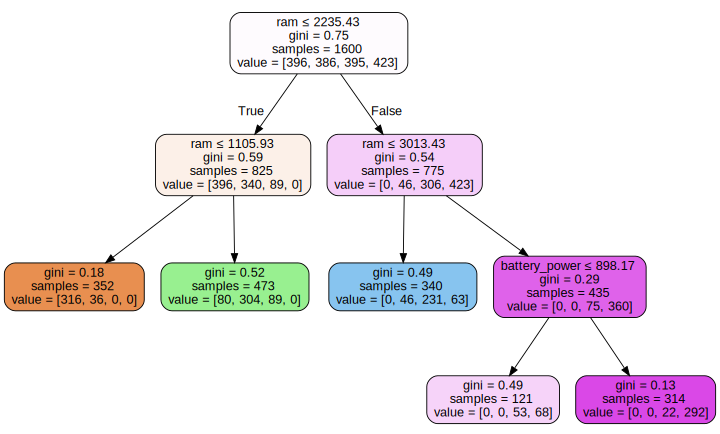

In [ ]:
draw_tree(decisionTree, x_data)

Cada nó possui as seguintes informações:
- gini: Medida de variância. Quanto maior a variância, mais erros de classificação haverá. Portanto, valores mais baixos do Índice de Gini permitem melhor classificação. É a probabilidade de que, se você escolher duas linhas de um grupo, obterá o mesmo resultado positivo todas as vezes. Se o grupo for todo igual, a probabilidade é 1,0 e 0,0 se forem todos diferentes:
- samples: número de amostras.
- value: como as amostras são agrupadas

Analisando o gráfico acima é possível observar que os nós mais a esquerda estão dentro da escala de **[0 - 1]** (mais baratos) e os nós mais da direita estão dentro da escala **[2 - 3]** (mais caros)

A Random Forest é um algoritmo de aprendizado supervisionado, composta por um conjunto de Decision Trees. Pode ser usado tanto para classificação (separar em categorias) quanto para regressão (prever um valor numérico). Em um problema de **classificação**, como no caso que estou trabalhando, cada árvore vota e a classe mais popular é escolhida como resultado final. Quanto mais árvores tiver, mais robusta é a floresta. A Random Forest cria árvores de decisão em amostras de dados selecionadas aleatoriamente, obtém previsões de cada árvore e seleciona a melhor solução por meio de votação. Tecnicamente, é um método de conjunto (baseado na abordagem de [dividir e conquistar](https://en.wikipedia.org/wiki/Divide-and-conquer_algorithm) de árvores de decisão geradas em um conjunto de dados dividido aleatoriamente)

O algorítimo funciona em quatro etapas:
- Selecionar amostras aleatórias de um determinado conjunto de dados
- Construir uma árvore de decisão para cada amostra e obtenha um resultado de previsão de cada árvore de decisão
- Realizar uma votação para cada resultado previsto
- Selecionar o resultado da previsão com mais votos como a previsão final

Legenda: Arquitetura de uma Random Forest

![random-forest-archtecure](https://user-images.githubusercontent.com/53023400/213031608-74a3a74c-b21d-4a1d-95ad-8c6eb37a6424.png)

Fonte: [Understanding Random Forests Classifiers in Python Tutorial](https://www.datacamp.com/tutorial/random-forests-classifier-python)

Para treinar nosso modelo, primeiramente iremos chamar o método *RandomForestClassifier()* que, do ponto de vista da implementação, cria uma instância de uma Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)

Após isso, iremos ajusta-los usando o método *fit()* passando nossos valores de X e Y

In [ ]:
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=1)

Agora passamos as variáveis dependetes para realizar algumas previsões

In [ ]:
y_pred = rf.predict(x_test)
y_pred

array([3, 0, 2, 0, 2, 0, 2, 3, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 0, 2, 1,
       1, 3, 3, 0, 2, 1, 2, 1, 3, 0, 1, 3, 0, 3, 1, 1, 2, 1, 0, 2, 1, 0,
       2, 0, 1, 0, 3, 1, 0, 3, 3, 0, 3, 3, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 1,
       0, 1, 2, 1, 1, 1, 1, 0, 3, 3, 0, 2, 3, 1, 3, 0, 3, 2, 2, 1, 0, 3,
       2, 3, 1, 2, 2, 2, 0, 0, 0, 0, 1, 3, 0, 3, 1, 0, 3, 3, 0, 3, 1, 3,
       0, 1, 0, 0, 3, 0, 0, 2, 0, 2, 0, 2, 1, 0, 1, 3, 0, 0, 3, 0, 3, 0,
       2, 0, 1, 3, 2, 0, 0, 3, 1, 1, 0, 2, 2, 3, 2, 0, 3, 3, 1, 1, 0, 3,
       2, 2, 0, 2, 2, 3, 1, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2,
       0, 2, 2, 2, 3, 1, 0, 0, 2, 3, 2, 0, 2, 3, 0, 2, 1, 0, 0, 3, 3, 0,
       0, 0, 2, 2, 3, 2, 0, 2, 0, 3, 1, 1, 1, 0, 0, 3, 3, 2, 1, 0, 1, 1,
       3, 0, 1, 2, 1, 1, 2, 0, 0, 0, 1, 3, 0, 0, 0, 1, 3, 1, 1, 2, 0, 0,
       2, 3, 2, 2, 0, 3, 1, 1, 0, 2, 1, 3, 1, 2, 3, 2, 0, 1, 1, 1, 3, 3,
       2, 1, 0, 2, 2, 0, 3, 3, 1, 1, 3, 2, 2, 2, 3,

Podemos comparar nossas previsões com os valores já informados

In [ ]:
np.stack((y_test,y_pred),axis=1)

array([[0, 0],
       [2, 2],
       [1, 1],
       [3, 3],
       [1, 1],
       [1, 2],
       [2, 2],
       [0, 0],
       [3, 3],
       [1, 1],
       [0, 0],
       [0, 1],
       [2, 2],
       [3, 3],
       [3, 2],
       [2, 2],
       [3, 3],
       [3, 3],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [3, 3],
       [2, 2],
       [2, 2],
       [0, 0],
       [0, 0],
       [0, 0],
       [3, 3],
       [0, 0],
       [1, 1],
       [1, 1],
       [2, 2],
       [0, 0],
       [3, 3],
       [0, 0],
       [2, 2],
       [3, 3],
       [2, 2],
       [0, 0],
       [2, 3],
       [3, 2],
       [2, 2],
       [1, 1],
       [3, 3],
       [1, 1],
       [3, 3],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 1],
       [1, 1],
       [3, 3],
       [0, 0],
       [0, 0],
       [1, 1],
       [3, 3],
       [3, 3],
       [1, 1],
       [0, 0],
       [0, 0],
       [3,

## 4.5 Calculando a acurácia

A função *score* do Scikit-learn pode ser usada para calcular a acurácia da Random Forest. Trata-se de um método para calcularemos uma medida de impureza, ou seja, quanto a divisão binária cria dois grupos em que as linhas de um grupo são semelhantes entre si ou diferentes. Sendo que quanto mais próximo de 1 melhor será a acurácia

In [ ]:
print("Random Forest Accuracy: ", rf.score(x_test,y_test))

Random Forest Accuracy:  0.895


# 5. Deploy

A aplicação pode ser acessada por meio do link: [Mobile Price Classification](https://huggingface.co/spaces/jackesfonseca/mobile-price)

![app](https://user-images.githubusercontent.com/53023400/213230559-fa6abaec-7773-4bab-a770-3f0502ba9828.png)